In [299]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
import torch.optim as optim
from scipy import linalg
import opt1d
os.chdir('/home/baly/projects/sopt_shape')

In [300]:
from lib.library import *
from lib.lib_ot import *
from lib.sliced_opt import *
from lib.lib_shape import *


In [301]:
# our method 1: 
# input, X, Y, N0, n_projetions,
# output Yhat_list

# load data 
i=19
j=2
label='female'
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)


#C=X.copy()
#K=600 # # of centers
# our method
#@nb.njit()

method='sopt_Gaussian'
sigma2=0.001
eps=0.001
n_projections=300
middle_point=100
record_index1=np.linspace(0,middle_point,50).astype(np.int64)
record_index2=np.linspace(middle_point,n_projections-1,50).astype(np.int64)
record_index=np.unique(np.concatenate((record_index1,record_index2)))
record_index.sort()


for eta in [0.05,0.10]:
    print('label is %s,method is %s, eta is %0.2f'%(label,method,eta))
    X0=data['X0']
    N0=X0.shape[0]
    X=data['X'+str(eta)]
    Y=data['Y'+str(eta)]

    time_start=time.time()
    Yhat_list,_=sopt_Gaussian_cuda(X,Y,N0,n_projections=n_projections,sigma2=sigma2,eps=eps,record_index=record_index)
    time_end=time.time()
    result={}
    result['Yhat_list']=Yhat_list
    result['time']=time_end-time_start
    torch.save(result,'result/3D_%s/%s_%0.2f.pt'%(label,method,eta))
    error=np.linalg.norm((Yhat_list[-1][0:N0]-Y[0:N0])/np.std(Y[0:N0]))/N0
    print('error', error)

female
label is female,method is sopt_Gaussian, eta is 0.05


KeyboardInterrupt: 

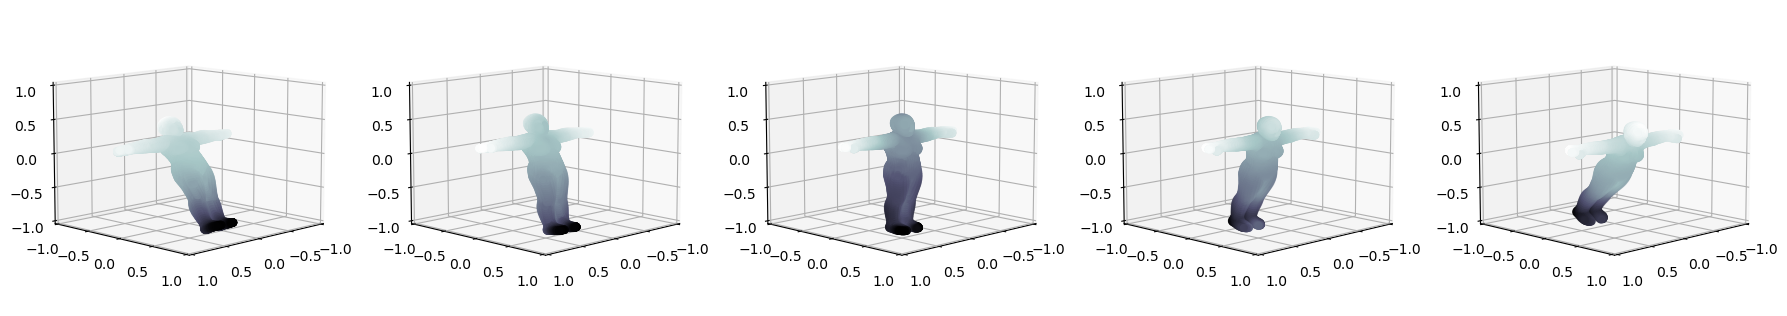

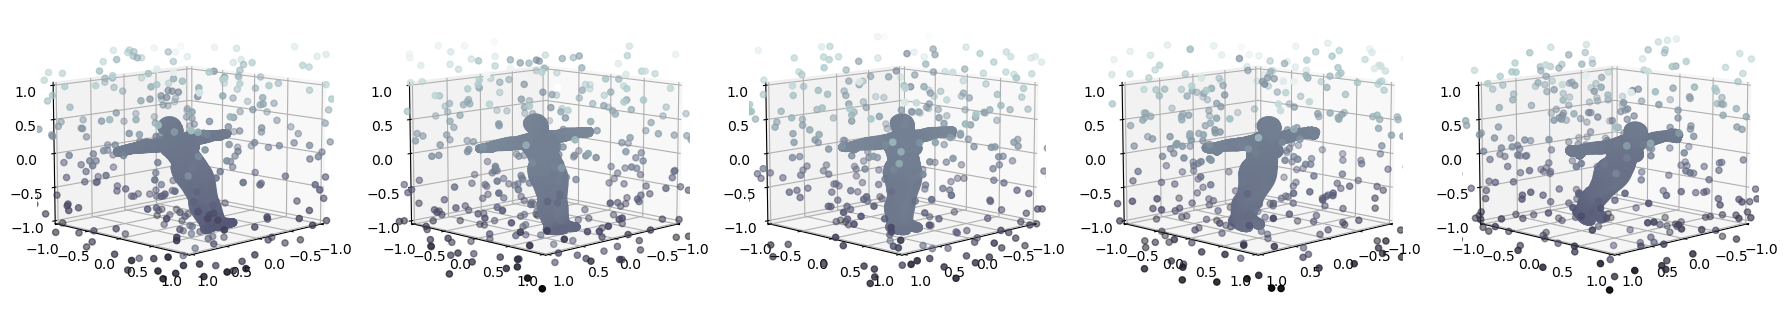

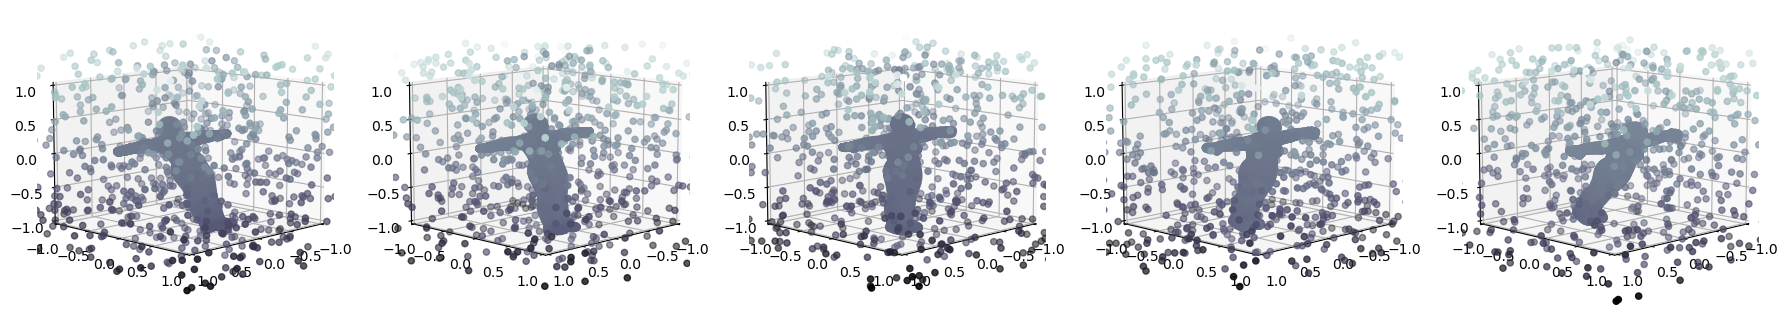

In [302]:
# do not run this one 
label='female'
data_list=torch.load('data/'+label+'_list.pt')
#data_list=np.array(data_list)
data_all={}

X=data_list[0] 
Y=data_list[-1]
n,d=X.shape


fig = plt.figure(figsize=(2*800/72,800/72))    
for n,i in enumerate(np.linspace(-.5,.5,5)):
    ax = fig.add_subplot(1, 5, n+1, projection='3d')
    data=data_list[n]
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
    ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
    ax.view_init(10, 45)
plt.show()
data_all['0']=data_list


# generate 5% noisy data
n,d=X.shape
data_listY1=[]
eta=0.05
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):

    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()

data_all[str(eta)]=data_listY1


# generate 10% noisy data
n,d=X.shape
data_listY1=[]
eta=0.10
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):
    
    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        x=data[:,0]
        y=data[:,1]
        z=data[:,2]
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()
data_all[str(eta)]=data_listY1

torch.save(data_all,'data/select_'+label+'.pt')


0
0.05
0.1


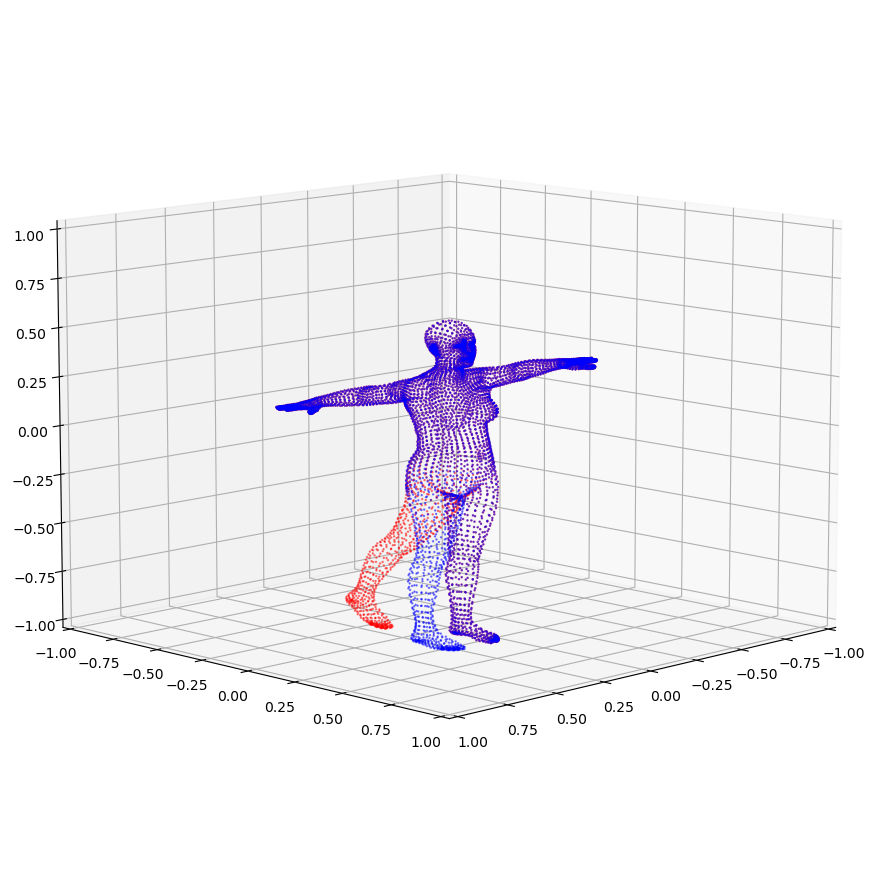

In [303]:
# do not run this one 
data_all=torch.load('data/select_'+label+'.pt')
for key in data_all:
    print(key)

i,j=19,2
X0=data_all['0'][i]
Y0=data_all['0'][j]
X1=data_all['0'][i]
Y1=data_all['0'][j]
make_plot(X1,Y1)


1.2735475874137929e-14


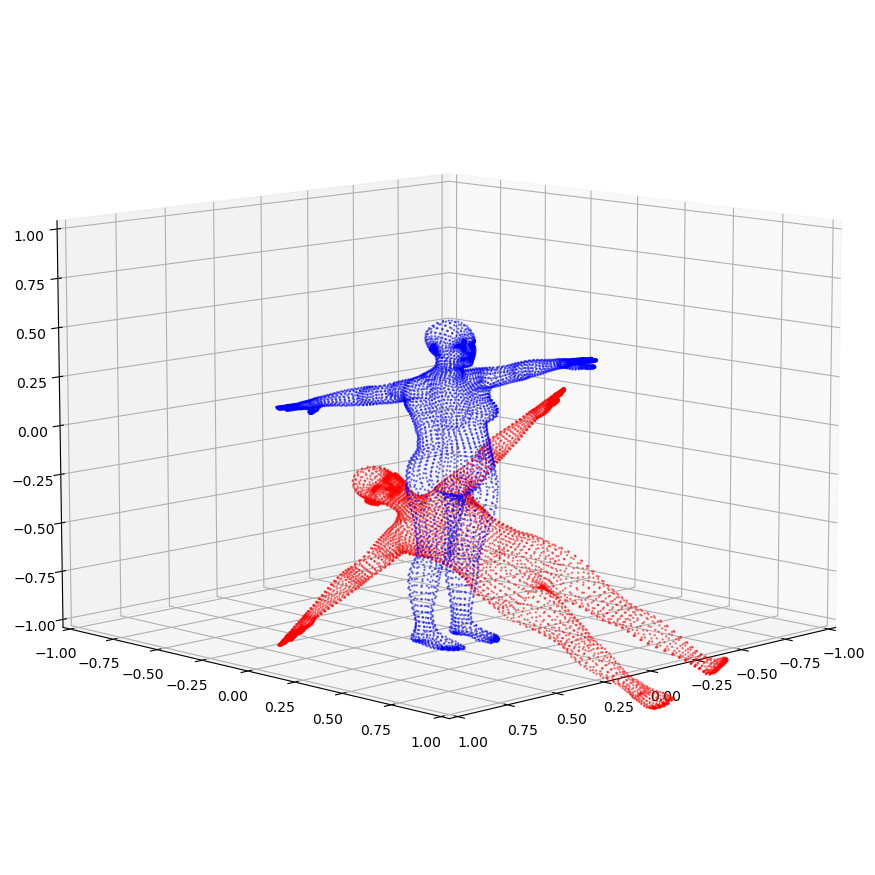

1.2735475874137929e-14


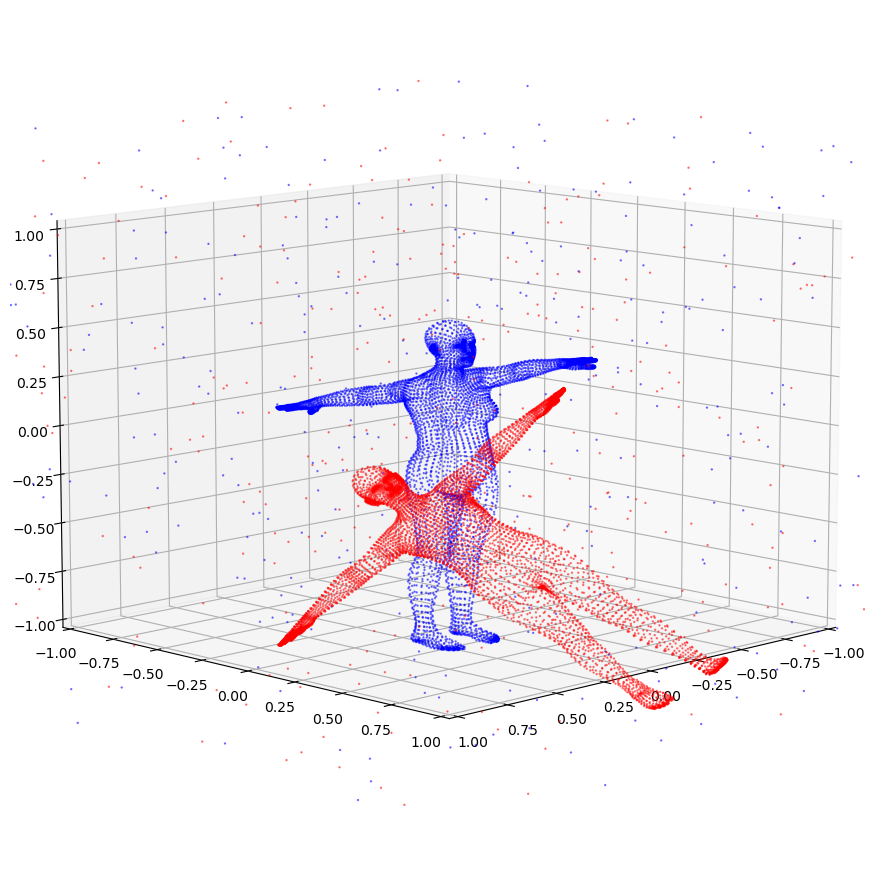

1.2735475874137929e-14


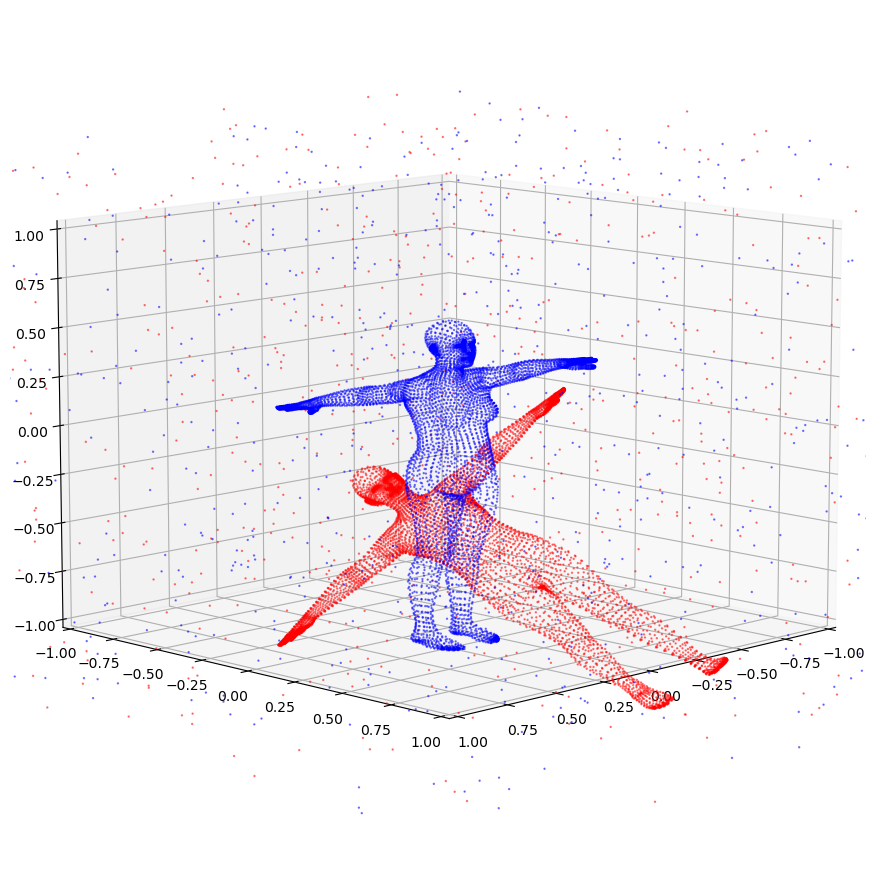

In [304]:
# do not run this cell 
# apply rotation and shift. 
eta=0 # 0.05, 0.10
X0=data_all[str(eta)][i]
N0=X0.shape[0]
data={}

for eta in [0, 0.05,0.10]:
    X=data_all[str(eta)][i]
    Y=data_all[str(eta)][j]
    theta_0=np.array([.0,.0,.0])+np.array([np.pi/6,-np.pi/5,np.pi/6])
    rotation_0=rotation_in(theta_0)
    beta_0=np.array([0.,-0.,0.])+np.array([0.2,-0.5,0.3])
    S_0=1.0 #0.8 
    X1=X[0:N0].dot(rotation_0)+beta_0
    X1=np.concatenate((X1,X[N0:]))
    N1=X1.shape[0]
    permutation=np.random.permutation(N1)
    X3=X1[permutation]
    theta_op=-theta_0 #np.array([np.pi/6,np.pi/4,-np.pi/5])
    rotation_op=rotation_re(theta_op)
    S_op=1/S_0
    beta_op=-S_op*beta_0.dot(rotation_op)
    X2=X1.dot(rotation_op)*S_op+beta_op
    print(np.linalg.norm(X2[0:N0]-X[0:N0]))

    data['X'+str(eta)]=X3
    data['Y'+str(eta)]=Y
    data['theta_op']=theta_op
    data['rotation_op']=rotation_op
    data['S_op']=S_op
    data['permutation'+str(eta)]=permutation
    make_plot(X3,Y)
torch.save(data,'data/%s_%d_%d.pt'%(label,i,j))


In [297]:
correspondence.shape

(6890,)

In [232]:
#@nb.njit(fastmath=True)
def kernel_matrix_Gaussian(c,x,sigma2):
    '''
    x: (n,d) numpy array
    c: (n,d) numpy array
    '''
   
    K,d=c.shape
    n=x.shape[0]
    #r2=np.zeros((n,K))
    diff_matrix=np.expand_dims(x,1)-np.expand_dims(c,0)
    r2=np.sum(np.square(diff_matrix),axis=2)
    Phi=np.zeros((n,d))
    Phi=Gaussian_kernel(r2,sigma2)
    return Phi



In [233]:

@nb.njit()
def permutation_inverse(permutation):
    N=permutation.shape[0]
    Domain=np.arange(N)
    mapping=np.stack((Domain,permutation))
    mapping_final=mapping[0].take(mapping[1].argsort())
    return mapping_final

In [249]:
X=np.random.rand(3)
Y=np.random.rand(4)
L=np.array([-1,1,3])
indice_X,indice_Y=X.argsort(),Y.argsort()

indice_Y_mapped=np.where(L>=0,indice_Y[L],-1)
mapping=np.stack((indice_X,indice_Y_mapped))
mapping_final=mapping[1].take(mapping[0].argsort())
print(X)
print(Y)
print(mapping_final)

[0.83732145 0.72331984 0.7884537 ]
[0.46167611 0.76716172 0.81632781 0.37119517]
[ 2 -1  0]


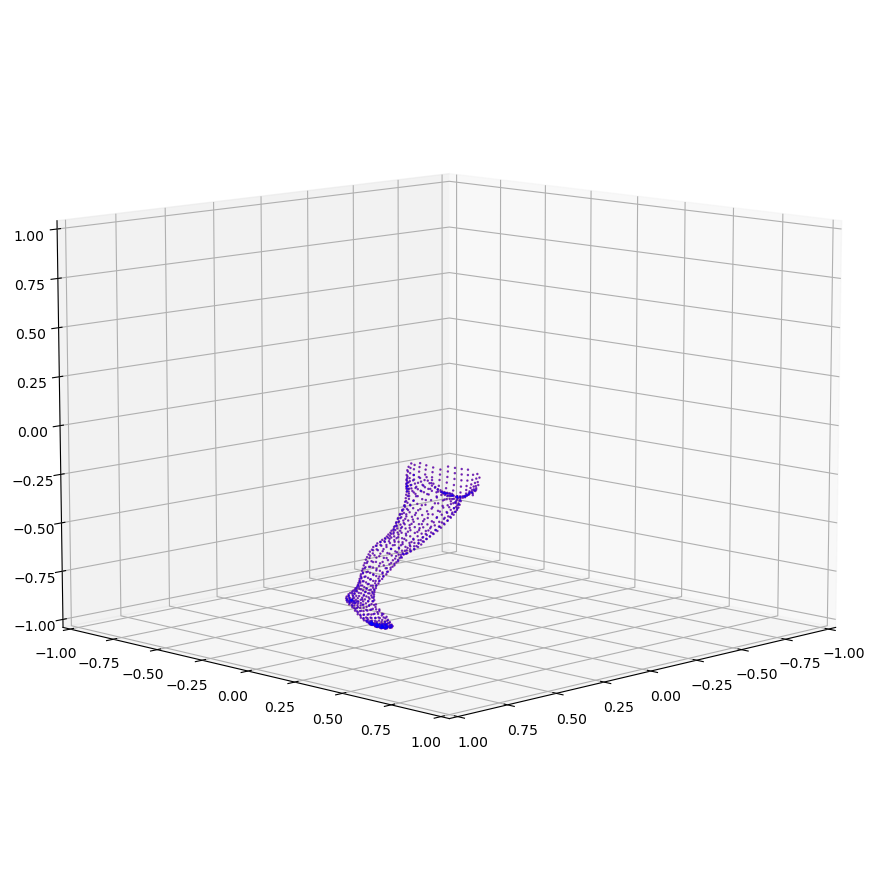

In [274]:

make_plot(C,C)

female


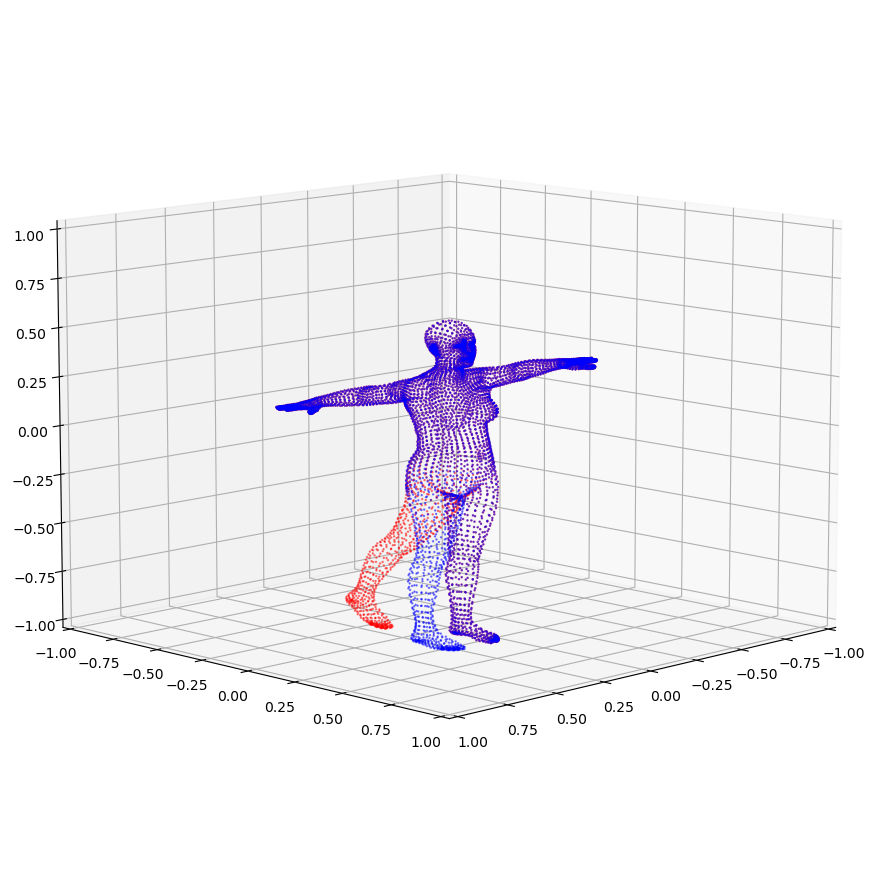

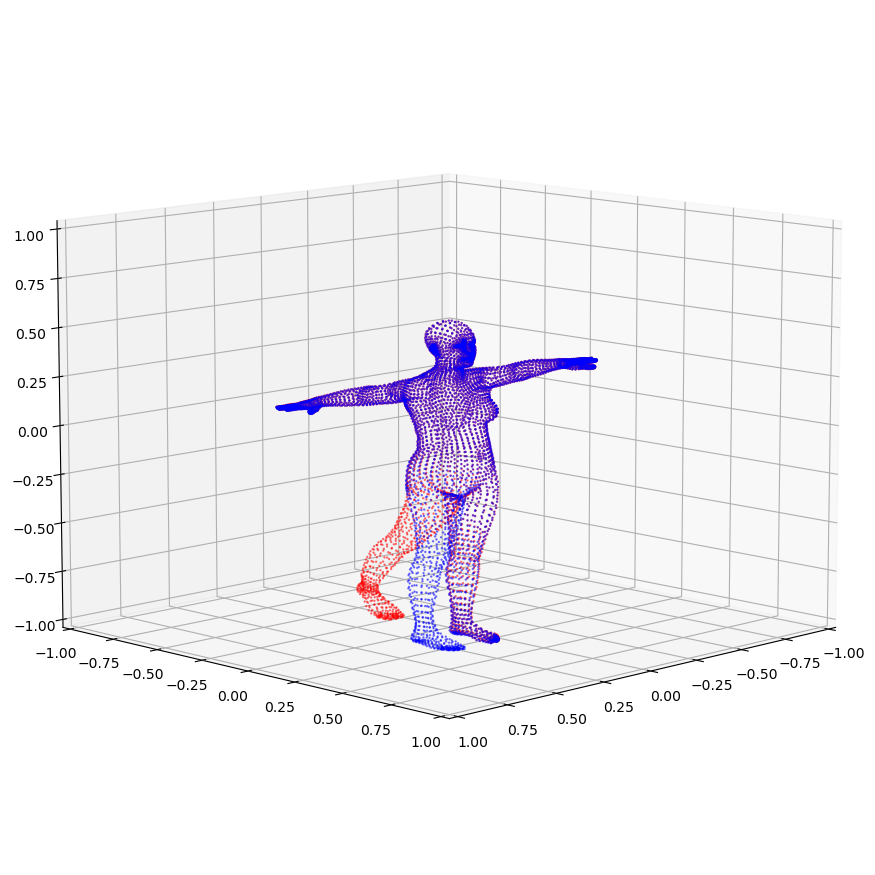

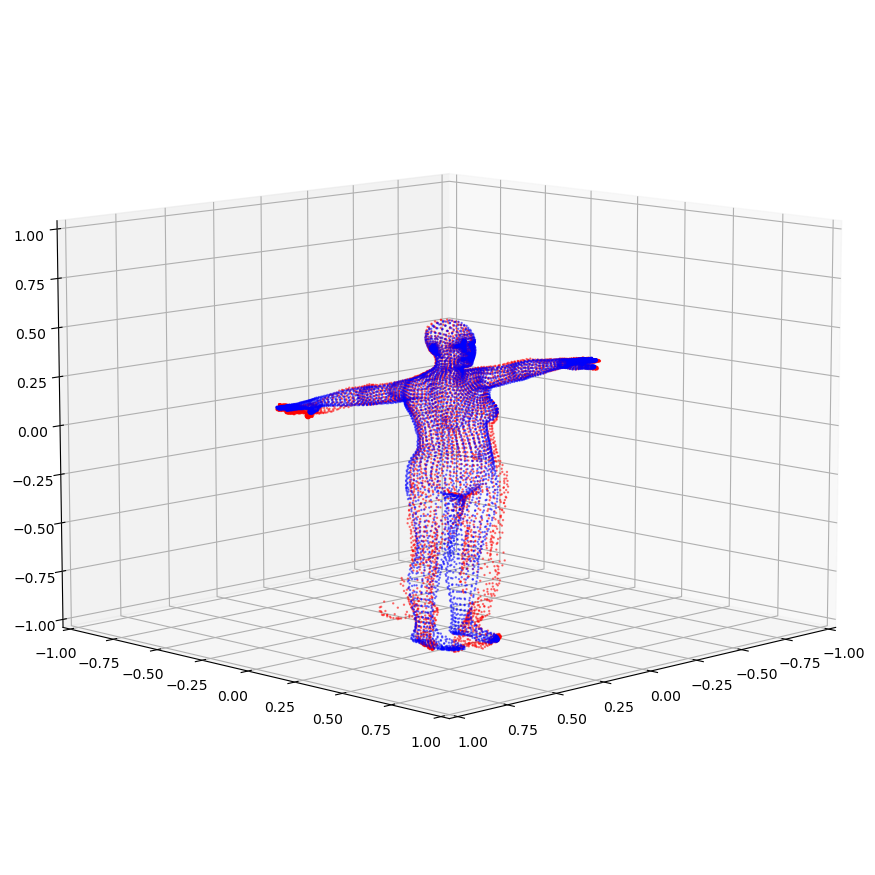

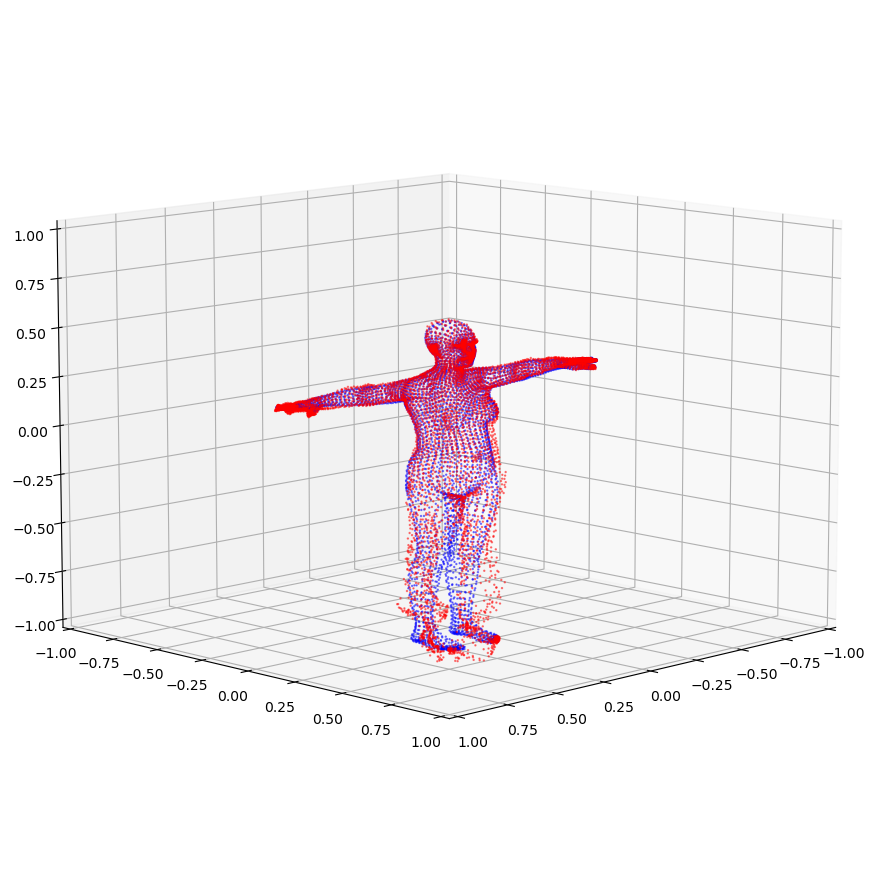

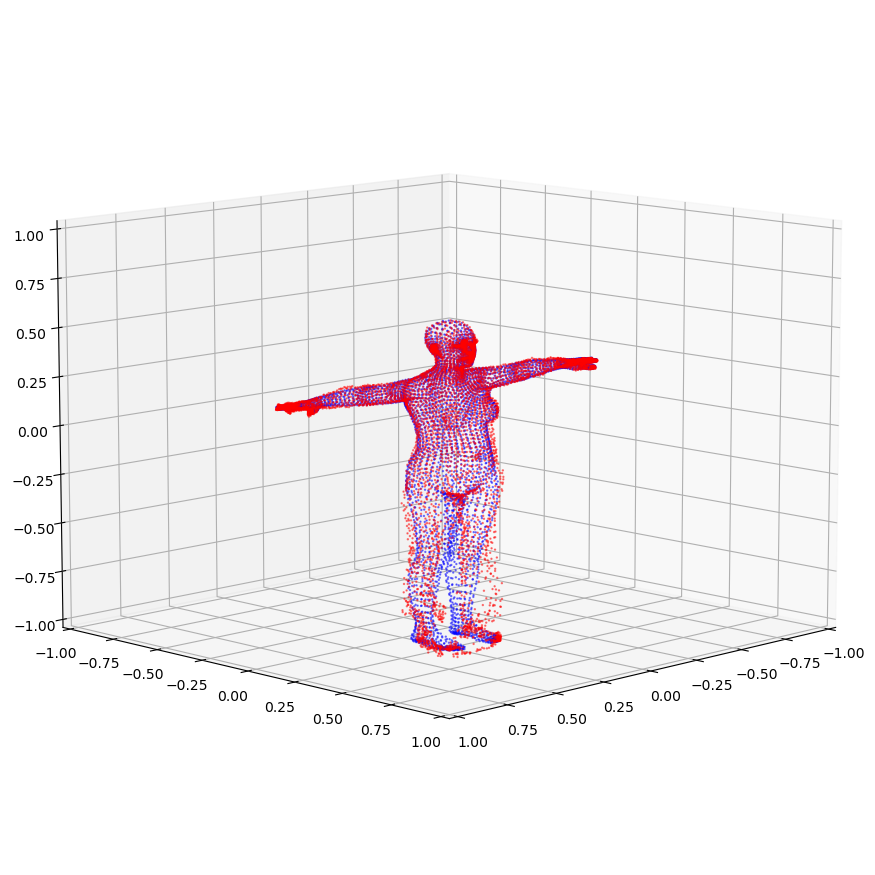

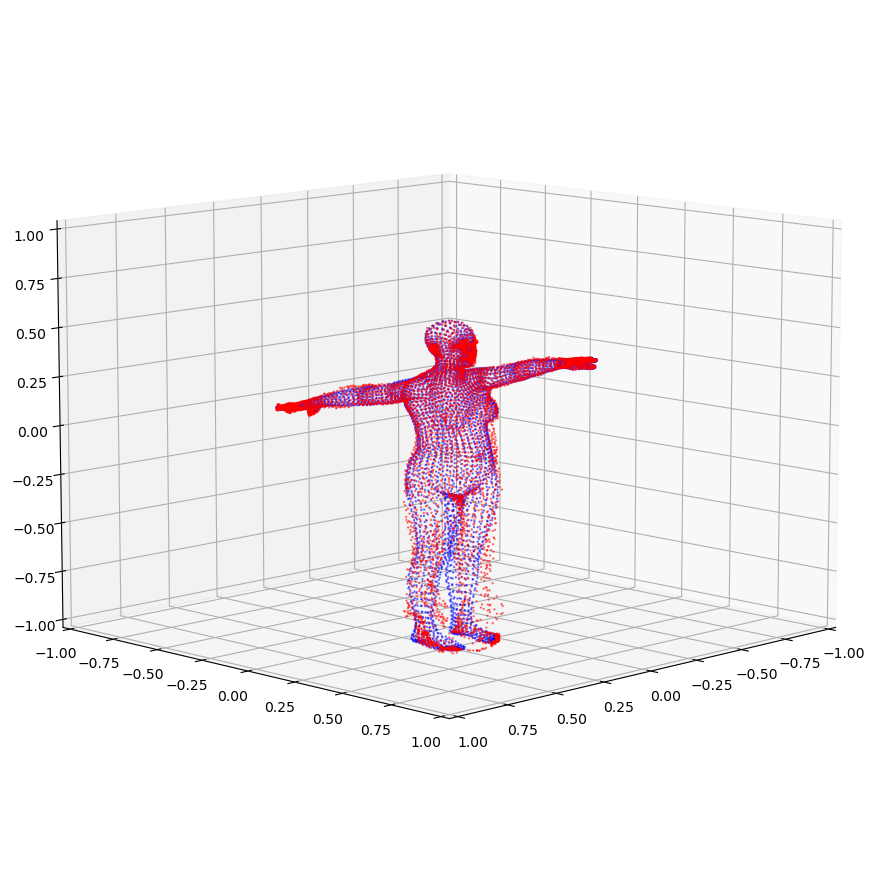

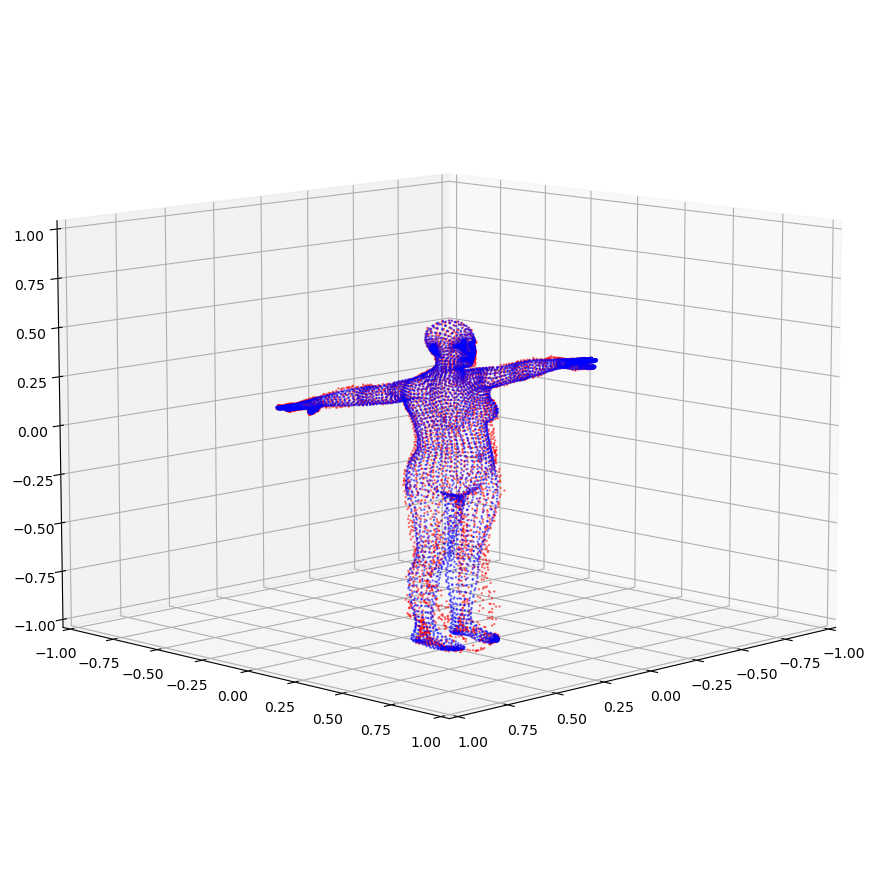

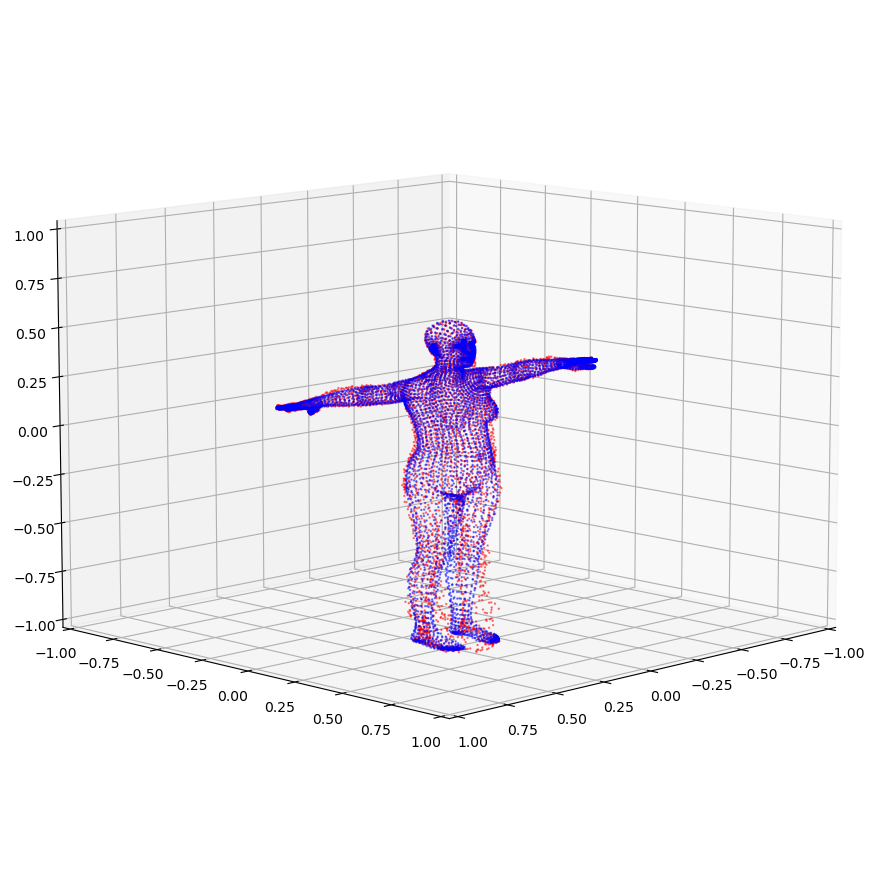

In [ ]:
# load data 
i=19
j=2
sigma2=2e-4
eta=0
label='female'
eps=1e-6
n_projections=1000
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)
record_index=[0,1,5,10]

X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]

correspondence=data['permutation'+str(eta)]
make_plot(X,Y)
N0=X0.shape[0]


N1,D=X.shape
K=N1
C=X.copy()

Phi=kernel_matrix_Gaussian(C,X,sigma2) 

# initlize 
R=np.eye(D)    
S=1.0 
beta=np.zeros(D) #vec_mean(Y)-vec_mean(S*X.dot(R)) 
alpha=np.zeros((C.shape[0],D))

#paramlist=[]
projections=random_projections(D,n_projections,1)
mass_diff=0
#b=0
b=np.log((N1-N0+1)/1)
Lambda=100*np.sum((vec_mean(Y)-vec_mean(X))**2)
Y_hat=Phi.dot(alpha)+S*X.dot(R)+beta
# make_plot(Y_hat,Y)

Domain_org=arange(0,N1)
Delta=Lambda/8
lower_bound=Lambda/10000
L=Domain_org.copy()

Yhat_list=list()
for (epoch,theta) in enumerate(projections):    
    # compute correspondence 
    Y_hat_theta=np.dot(theta,Y_hat.T)
    Y_theta=np.dot(theta,Y.T)

    Y_hat_indice=Y_hat_theta.argsort()
    Y_indice=Y_theta.argsort()
    Y_hat_s=Y_hat_theta[Y_hat_indice]
    Y_s=Y_theta[Y_indice]
    obj2,phi,psi,piRow,piCol=opt1d.solve(Y_hat_s,Y_s,Lambda)
#     #obj,phi,psi,piRow,piCol=solve_opt(Y_hat_s,Y_s,Lambda)

    L=piRow.copy().astype(np.int64)
    L=recover_indice(Y_hat_indice,Y_indice,L)
    


    #L=np.arange(N1)
    #L=correspondence
    Domain=Domain_org[L>=0]

    #move selected Y_hat
    mass=Domain.shape[0]
    # if Domain.shape[0]>=1:
    Range=L[L>=0]
    Y_hat[Domain]+=np.expand_dims(Y_theta[Range]-Y_hat_theta[Domain],1)*theta

    # find optimal R,S,beta, conditonal on alpha
    
    # Y_prime2=Y_hat[Domain]-Phi[Domain].dot(alpha)
    # R,S=recover_rotation(Y_prime2,X[Domain])
    # beta=vec_mean(Y_prime2)-vec_mean(X[Domain].dot(R))

    # update Y_hat by alpha, Phi 
#    elif epoch%2==1:
    Y_prime=Y_hat[Domain]-X[Domain].dot(R)-beta
    alpha=recover_alpha(Phi[Domain],Y_prime)
    #error2=np.linalg.norm(Y_prime-Phi.dot(alphaa))
    
    #print('error from alpha is',np.linalg.norm(Phi.dot(alpha)[Domain]-Y_prime))

    # update selected points 
    # model 1
    Y_hat=Phi.dot(alpha)+S*X.dot(R)+beta

    # update lambda 
    N=(N1-N0)*1/(1+b*(epoch/500))+N0
    mass_diff=mass-N
    if mass_diff>N*0.009:
        Lambda-=Delta 
    if mass_diff<-N*0.003:
        Lambda+=Delta
        Delta=Lambda*1/8
    if Lambda<Delta:
        Lambda=Delta
        Delta=Delta*1/2
    if Delta<lower_bound:
        Delta=lower_bound
    if epoch%10==0:
        make_plot(Y_hat,Y)
    #error=np.linalg.norm((Y_hat[0:N0]-Y[correspondence])/np.std(Y[0:N0]))/N0
    #print('error', error)
    
    # if epoch in record_index or epoch==n_projections-1:
    #     Yhat_list.append(Y_hat)
            

In [ ]:
error=np.linalg.norm((Y_hat[0:N0]-Y[correspondence])/np.std(Y[0:N0]))/N0
print('error', error)

In [258]:
X=np.random.rand(5,3)
Y=X+np.random.rand(5,3)
signma2=1e-4
Phi=kernel_matrix_Gaussian(X,X,sigma2)
alpha=recover_alpha(Phi,Y)
Yhat=Phi.dot(alpha)
error=np.linalg.norm(Yhat-Y)
print(error)

0.0003618981229353809


In [209]:
data=torch.load('data/female_%d_%d.pt'%(i,j))
X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]
#make_plot(X,Y)
N0=X0.shape[0]

N1,D=X.shape
C=X.copy()
sigma2=1e-4
Phi=kernel_matrix_Gaussian(C,X,sigma2) 


AttributeError: 'numpy.ndarray' object has no attribute 'diag'

In [210]:
Phi.diag()

AttributeError: 'numpy.ndarray' object has no attribute 'diag'

female


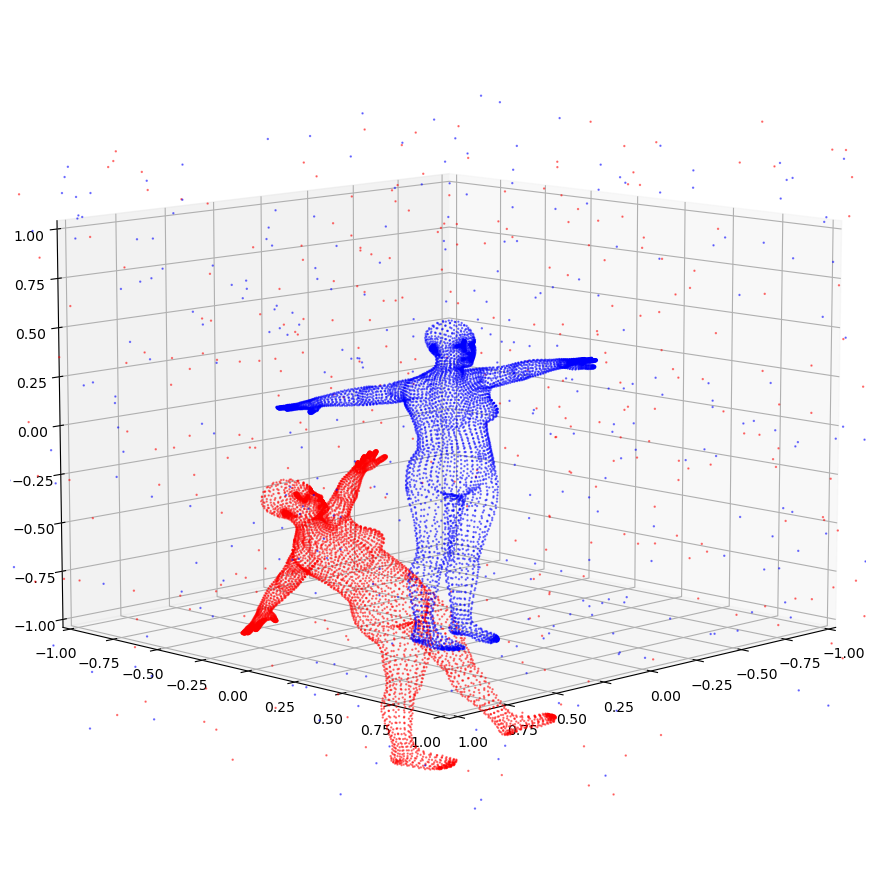

epoch 0
Lambda 40.34823162085958


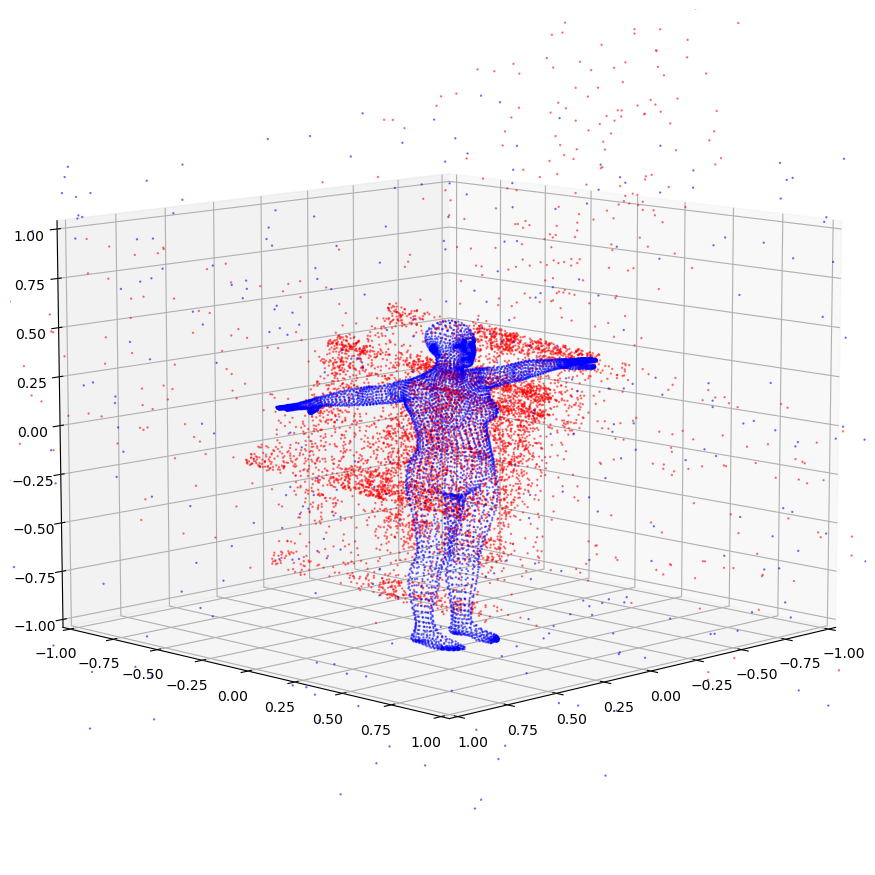

error 0.03145222786552691
epoch 1
Lambda 40.34823162085958


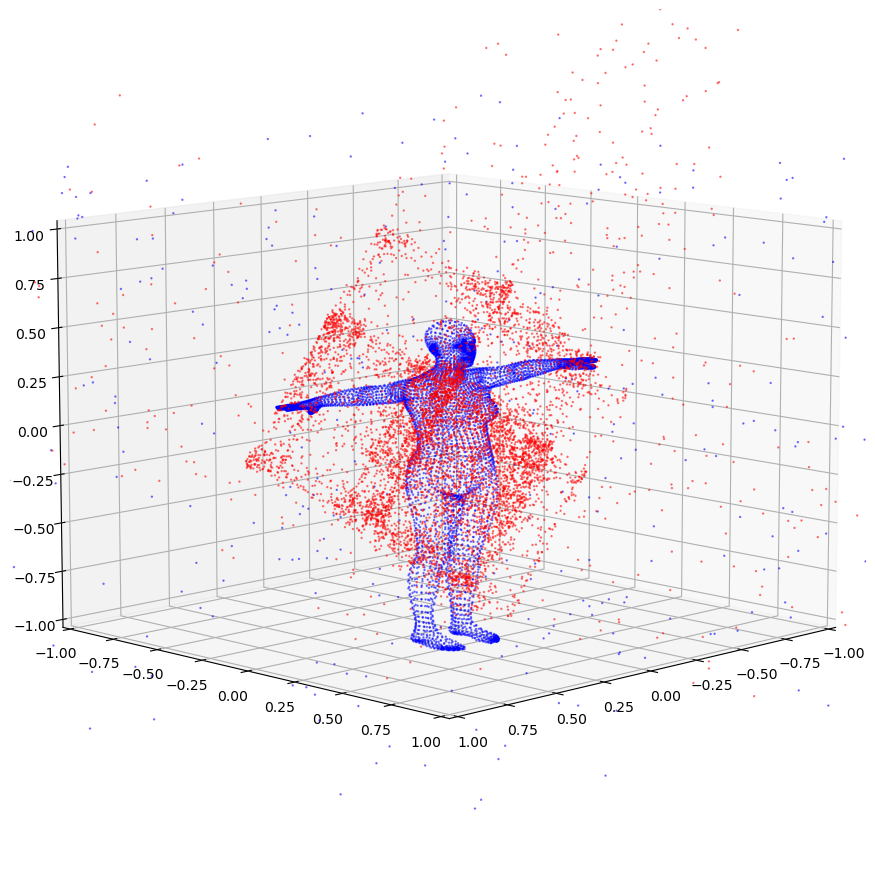

error 0.03143254549663081
epoch 2
Lambda 40.34823162085958


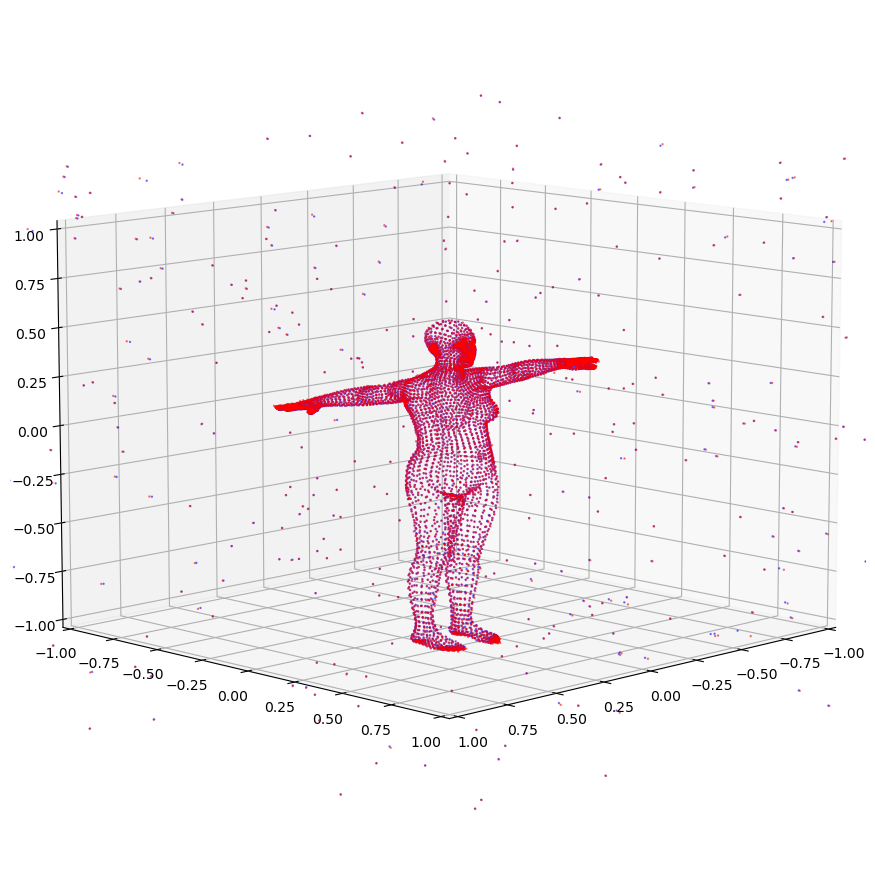

error 0.031309337402191176
epoch 3
Lambda 40.34823162085958


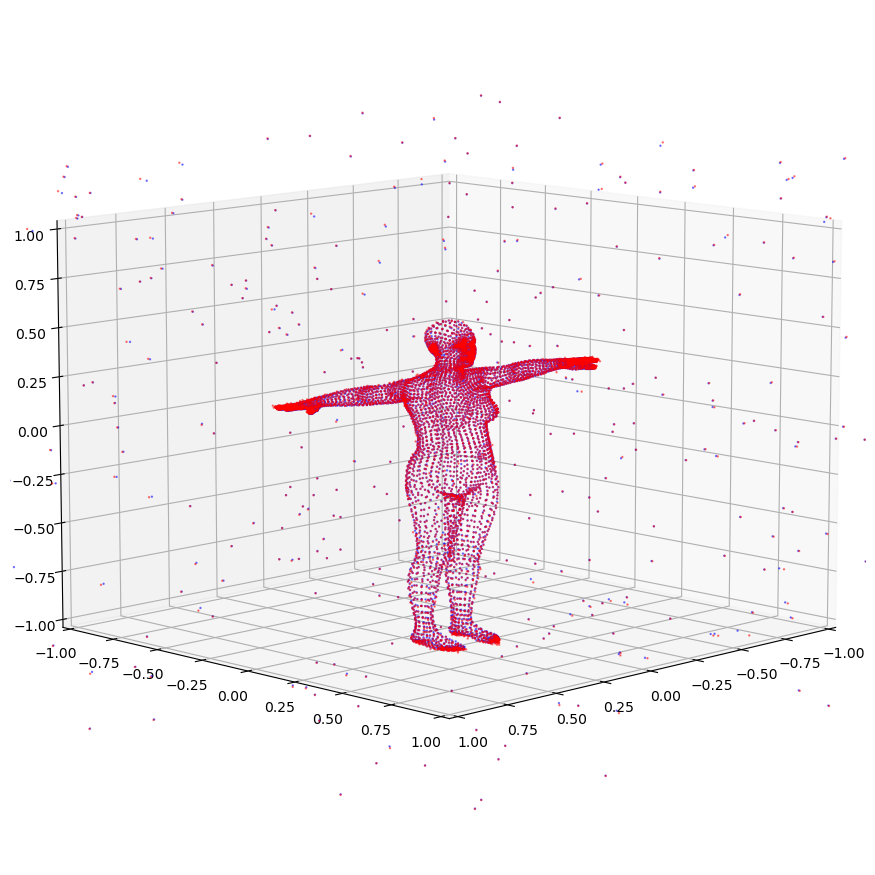

error 0.031309337402191176
epoch 4
Lambda 40.34823162085958


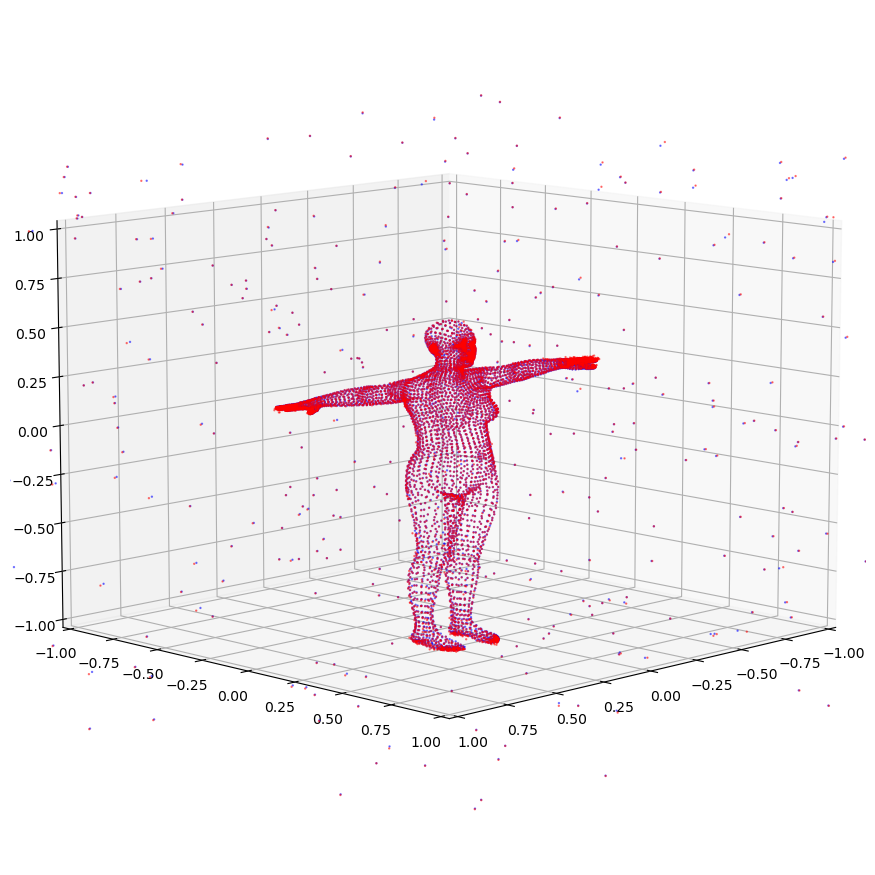

error 0.031309337402191176
epoch 5


KeyboardInterrupt: 

In [146]:
# TPS method

# load data 
i=19
j=2
eta=0.05
label='female'
eps=1e-5
n_projections=50
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)
recod_index=[0,1,5,10]
data=torch.load('data/female_%d_%d.pt'%(i,j))
X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]
make_plot(X,Y)
N0=X0.shape[0]

N1,D=X.shape
C=X.copy()
Phi0=kernel_matrix_TPS(C,X,D) 
X_bar=np.hstack((np.ones((X.shape[0],1)),X))
# initlize 
R=np.eye(D)    
S=1.0
beta=np.mean(Y,0)-np.mean(X.dot(S).dot(R),0) #np.zeros(3) #vec_mean(Y)-vec_mean(X.dot(S).dot(R)) 
alpha=np.zeros((C.shape[0],D))
B=np.vstack((beta,R))

#paramlist=[]
projections=random_projections(D,n_projections,1)
mass_diff=0
b=np.log((N1-N0+1)/1)
Lambda=60*np.sum((Y.mean(0)-X.mean(0))**2)
Y_hat=Phi0.dot(alpha)+X_bar.dot(B)
# make_plot(Y_hat,Y)

Domain_org=arange(0,N1)
Delta=Lambda/8
lower_bound=Lambda/10000
L=Domain_org.copy()
Domain_org=np.random.permutation(N1)
Range=np.random.permutation(N1)
Yhat_list=list()

for (epoch,theta) in enumerate(projections):
    print('epoch',epoch)
    # compute correspondence 
    Y_hat_theta,Y_theta=np.dot(theta,Y_hat.T),np.dot(theta,Y.T)

    # Y_hat_indice,Y_indice=Y_hat_theta.argsort(),Y_theta.argsort()
    # Y_hat_s,Y_s=Y_hat_theta[Y_hat_indice],Y_theta[Y_indice]
    # obj,phi,psi,piRow,piCol=solve_opt(Y_hat_s,Y_s,Lambda)
    # L=piRow.copy()
    # L=recover_indice(Y_hat_indice,Y_indice,L)
    # Domain=Domain_org[L>=0]

    #move selected Y_hat
    # mass=Domain.shape[0]
    # Range=L[Domain]
    # L=np.arange(n)
    Domain=Domain_org
    Y_hat[Domain]+=np.expand_dims(Y_theta[Range]-Y_hat_theta[Domain],1)*theta

    # find optimal alpha, B
    #Phi_T,X_bar_select,Y_select=Phi0[Domain][:,Domain],X_bar[Domain],Y_hat[Domain]
    #print(Phi_T.shape)
    #alpha1,B=TPS_recover_parameter(Phi_T,X_bar_select,Y_select,eps)
    
    #alpha[Domain]=alpha1
    #print(alpha.max())
    alpha,B=TPS_recover_parameter(Phi0,X_bar,Y_hat,eps)


    # update selected points 
    # our model
    Y_hat=Phi0.dot(alpha)+X_bar.dot(B)


    # update lambda 
    N=(N1-N0)*1/(1+b*(epoch/500))+N0
    mass_diff=mass-N
    if mass_diff>N*0.009:
        Lambda-=Delta 
    if mass_diff<-N*0.003:
        Lambda+=Delta
        Delta=Lambda*1/8
    if Lambda<Delta:
        Lambda=Delta
        Delta=Delta*1/2
    if Delta<lower_bound:
        Delta=lower_bound
    print('Lambda',Lambda)

    # recode point cloud in the process
    if epoch in recod_index or epoch==n_projections-1:
        Yhat_list.append(Y_hat)

    make_plot(Y_hat,Y)
    error=np.linalg.norm((Yhat_list[-1][0:N0]-Y[0:N0])/np.std(Y[0:N0]))/N0
    print('error', error)
#     elif epoch%100==0: 
#         make_plot(Y_hat,Y)
        






In [126]:
Domain=np.arange(30)
Phi_T,X_bar_select,Y_select=Phi0[Domain][:,Domain],X_bar[Domain],Y_hat[Domain]
print(Phi_T.shape)
alpha,B=TPS_recover_parameter(Phi_T,X_bar_select,Y_select,eps)
print(X.shape)

(30, 30)
(6890, 3)


In [113]:
n,d=X_bar.shape
n,K=Phi_T.shape
diag_M=np.zeros((n,K))
np.fill_diagonal(diag_M, epsilon)
M=Phi_T+diag_M
Q, R0 = linalg.qr(X_bar)
Q1,Q2=Q[:,0:d],Q[:,d:n]
R=R0[0:d,:]
alpha=Q2.dot(np.linalg.inv(Q2.T.dot(M).dot(Q2))).dot(Q2.T).dot(Y)
B=np.linalg.inv(R).dot(Q1.T).dot(Y-Phi_T.dot(alpha))

ValueError: shapes (26,7234) and (30,30) not aligned: 7234 (dim 1) != 30 (dim 0)

In [74]:
Q2.T.dot(Phi_T).dot(Q2).shape

(6886, 6886)

In [73]:
diag_M.shape

(6890, 6890)

In [50]:
alpha.max()

18941.719702825638

In [ ]:
error_list=list()
for Yhat in Yhat_list:
    error=np.linalg.norm(Yhat[0:N0][etamutation]-Y[0:N0])
    error_list.append(error)
    